# (Figure4_part2)-Profiling the Epithelial Cells Infected with H. pylori at Single-Cell Level.

In [10]:
import anndata as ad
import scanpy as sc
import omicverse as ov
import os
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_style('white')

font_path = 'Gastric/Arial.ttf'
front_prop = FontProperties(fname=font_path)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [11]:
adata = sc.read_h5ad('Gastric/Data/Epi_anno.h5ad')
adata.uns['Epi_celltype_colors'] = [ov.pl.blue_color[2],ov.pl.blue_color[3],ov.pl.red_color[4],ov.pl.blue_color[5],
                                  ov.pl.red_color[0],ov.pl.red_color[2],ov.pl.red_color[1]]
adata_Enterocytes = adata[adata.obs['Epi_celltype'].isin(['IM_Enterocytes'])]
adata_Enterocytes

View of AnnData object with n_obs × n_vars = 5195 × 2000
    obs: 'Group_number', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'major_celltype', 'Person', 'Epi_celltype'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Group_number_colors', 'Person_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_Epi_celltype', 'dendrogram_Group_number', 'dendrogram_leiden', 'dendrogram_major_celltype', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'major_celltype_colors', 'neighbors', 'paga', 'pca', 'umap', 'Epi_celltype_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [12]:
sc.pp.neighbors(adata_Enterocytes, use_rep="X_scVI", metric="cosine",n_neighbors=15, random_state = 112)
#sc.tl.leiden(Epi,resolution=1)
sc.tl.paga(adata_Enterocytes)
sc.pl.paga(adata_Enterocytes, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_Enterocytes,init_pos='paga')

computing neighbors


2024-08-18 16:13:11.678620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 16:15:47.191058: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 16:17:48.842755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib:/opt/slurm/lib/slurm:/opt/slurm/lib:/opt/slurm/lib/slurm:/opt/slurm/lib:

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:29)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [13]:
pathway_dict=ov.utils.geneset_prepare('Gastric/Reference/genesets/GO_Biological_Process_2021.txt',organism='Human')
#pathway_dict

computing score 'Lipometabolism pathway'
    finished: added
    'Lipometabolism pathway', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)


[<AxesSubplot: title={'center': 'Lipometabolism pathway'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <AxesSubplot: title={'center': 'Sample'}, xlabel='X_umap1', ylabel='X_umap2'>]

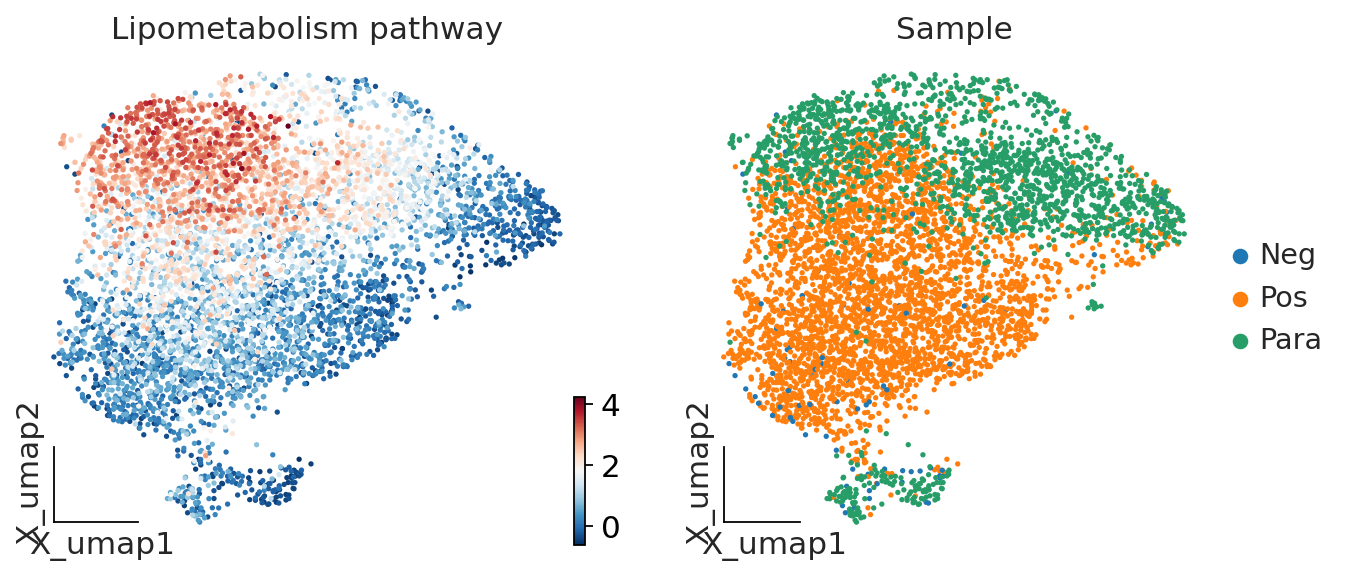

In [14]:
select_gene =  pathway_dict['regulation of intestinal lipid absorption (GO:1904729)']
#select_gene = pathway_dict['T cell activation (GO:0042110)']
sc.tl.score_genes(adata_Enterocytes, select_gene, score_name='Lipometabolism pathway')
ov.pl.embedding(adata_Enterocytes,
                basis='X_umap',
                color=['Lipometabolism pathway','Sample',],
                frameon='small',cmap='RdBu_r',
                show=False,)

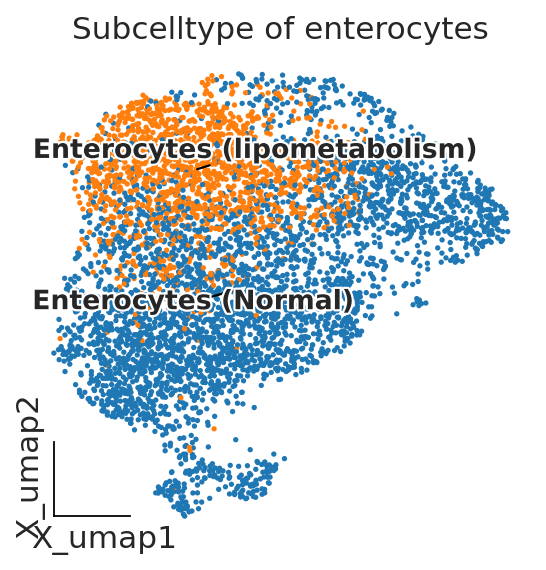

In [15]:
from matplotlib import patheffects
import matplotlib.pyplot as plt
adata_Enterocytes.obs['Lipometabolism_type'] = 'Enterocytes (Normal)'
adata_Enterocytes.obs.loc[adata_Enterocytes.obs['Lipometabolism pathway']>2,'Lipometabolism_type']='Enterocytes (lipometabolism)'
fig,ax=plt.subplots( figsize = (4,4))
ov.pl.embedding(adata_Enterocytes,
                basis='X_umap',
                color=['Lipometabolism_type',],title='Subcelltype of enterocytes',
                frameon='small',cmap='RdBu_r',ax=ax,legend_loc=None,
                show=False,)
ov.pl.embedding_adjust(
    adata_Enterocytes,
    groupby='Lipometabolism_type',
    exclude=("OL",),  
    basis='X_umap',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)
fig.savefig('Gastric/Figure_new/Figure5/Figure5_C_1.png', dpi=300,bbox_inches = 'tight')

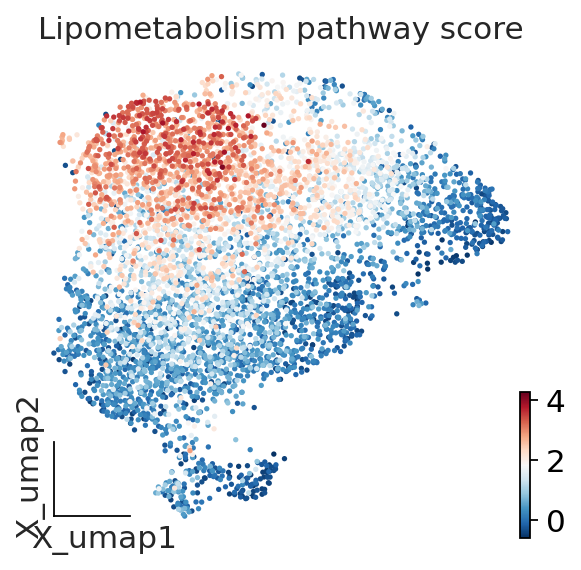

In [16]:
fig,ax=plt.subplots( figsize = (4,4))
ax = ov.pl.embedding(adata_Enterocytes,
                basis='X_umap',
                color=['Lipometabolism pathway',],title='Lipometabolism pathway score',
                frameon='small',cmap='RdBu_r', ax=ax,
                show=False,)
fig.savefig('Gastric/Figure_new/Figure5/Figure5_C_2.png', dpi=300,bbox_inches = 'tight')

In [19]:
adata_Enterocytes_obs = adata_Enterocytes.obs
adata_Enterocytes = adata_Enterocytes.raw.to_adata()

In [20]:
adata_Enterocytes = adata_Enterocytes[:,~adata_Enterocytes.var_names.str.contains('RPS')]
adata_Enterocytes = adata_Enterocytes[:,~adata_Enterocytes.var_names.str.contains('RPL')]
adata_Enterocytes.obs = adata_Enterocytes_obs
#normalize and high variable genes (HVGs) calculated
adata_Enterocytes=ov.pp.preprocess(adata_Enterocytes,mode='shiftlog|pearson',n_HVGs=3000,)

#save the whole genes and filter the non-HVGs
adata_Enterocytes.raw = adata_Enterocytes
adata_Enterocytes = adata_Enterocytes[:, adata_Enterocytes.var.highly_variable_features]

adata_Enterocytes.layers['lognorm'] = adata_Enterocytes.X
adata_Enterocytes

Begin robust gene identification
After filtration, 26102/32115 genes are kept. Among 26102 genes, 21216 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 2.388261556625366 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 5195 × 3000
    obs: 'Group_number', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'major_celltype', 'Person', 'Epi_celltype', 'Lipometabolism pathway', 'Lipometabolism_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'dispersions', 'dispersions_norm', 'percent_cells', 'robust', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'Group_number_colors', 'Person_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dendrogram_Epi_celltype', 'dendrogram_Group_number', 'dendrogram_leiden', 'dendrogram_major_celltype', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'major_celltype_colors', 'neighbors', 'paga', 'pca', 'umap', 'Epi_celltype_colors', 'Lipometabolism_type_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'lognorm

In [38]:
# PC
dds=ov.bulk.pyDEG(adata_Enterocytes.to_df().T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')
treatment_groups=adata_Enterocytes[adata_Enterocytes.obs['Lipometabolism_type']=='Enterocytes (lipometabolism)'].obs.index.tolist()
control_groups=adata_Enterocytes[adata_Enterocytes.obs['Lipometabolism_type']=='Enterocytes (Normal)'].obs.index.tolist()
result=dds.deg_analysis(treatment_groups,control_groups,method='wilcox')
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=1,
                   pval_threshold=0.05,
                   logp_max=50)


... drop_duplicates_index success
... Fold change threshold: 1


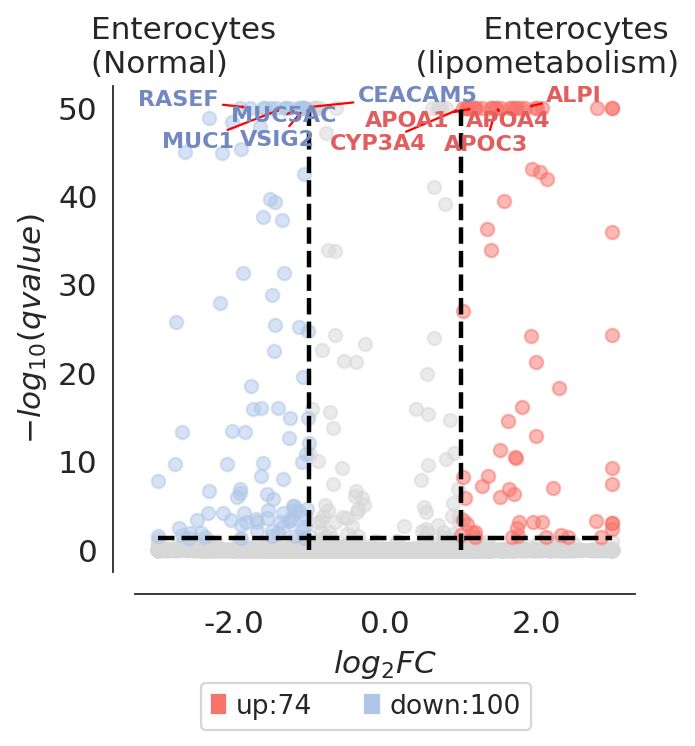

In [39]:
dds.result.loc[dds.result.loc[:,'log2FC']<-3,'log2FC']=-3
dds.result.loc[dds.result.loc[:,'log2FC']>3,'log2FC']=3
ax = dds.plot_volcano(title='Enterocytes                     Enterocytes \n(Normal)                   (lipometabolism)',figsize=(4,4)
                      ,down_color='#aec7e8',up_color='#f8736a', 
                 plot_genes_num=10,plot_genes_fontsize=10,legend_bbox=(0.82, -0.2),)#plot_genes=['GZMK','CTLA4','GNLY'])
plt.savefig('Gastric/Figure_new/Figure5/Figure5_E.png', dpi=300,bbox_inches = 'tight')

In [40]:
def split_long_name(name, threshold=50):
    if len(name) > threshold:
        middle = len(name) // 2
        split_point = middle
        while split_point > 0 and name[split_point] != ' ':
            split_point -= 1
        if split_point > 0:  
            return name[:split_point] + '\n' + name[split_point+1:]
        else:
            return name  
    else:
        return name

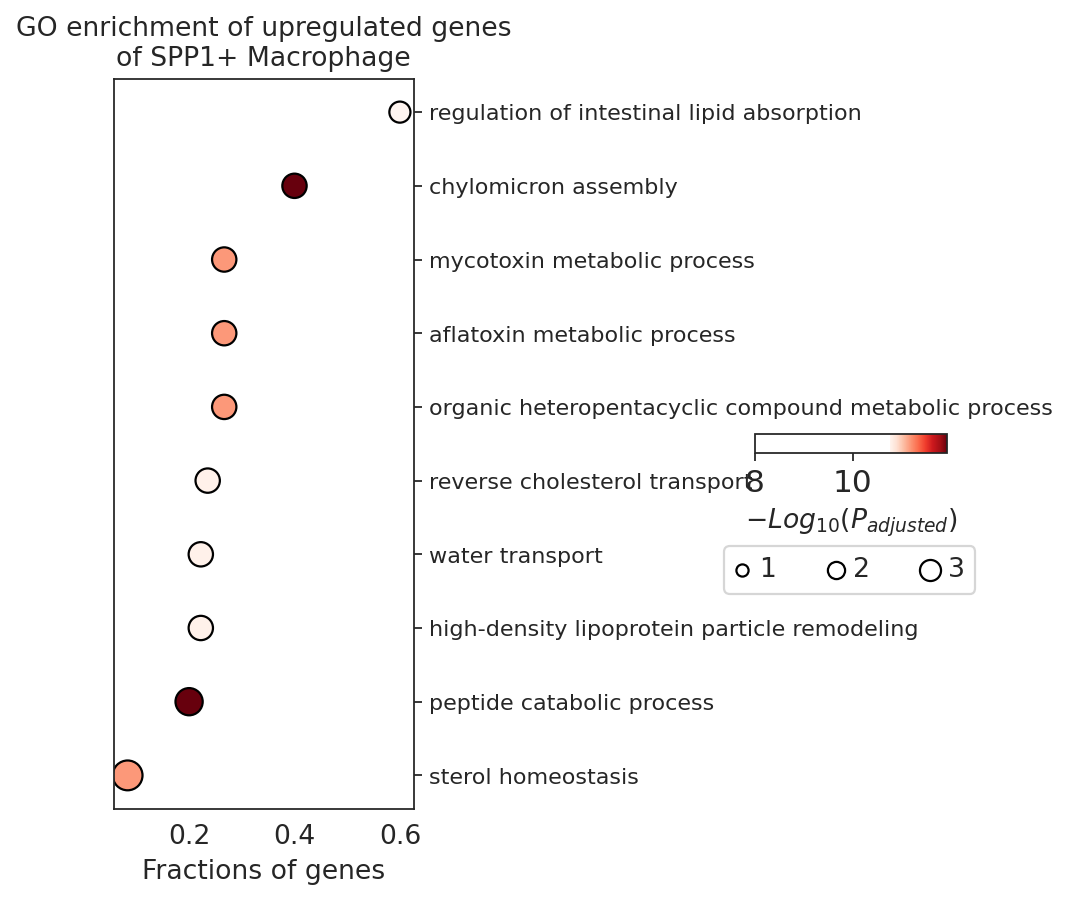

In [56]:
pathway_dict=ov.utils.geneset_prepare('Gastric/Reference/genesets/GO_Biological_Process_2021.txt',organism='Human')
deg_genes = dds.result.loc[(dds.result['sig']!='normal')&(dds.result['log2FC']>0)].index.tolist()
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='Human')
ax = ov.bulk.geneset_plot(enr,figsize=(2.4,6),fig_title='GO enrichment of upregulated genes\nof SPP1+ Macrophage',
                          node_size=[1, 2, 3],
                          cax_loc=[1.85, 0.52, 0.5, 0.02],
                          bbox_to_anchor_used=(-0.23, -8),node_diameter=30,custom_ticks=[8,10],
                        cmap='Reds')

In [57]:
enr['Term'].tolist()

['ERK1 and ERK2 cascade (GO:0070371)',
 'acylglycerol homeostasis (GO:0055090)',
 'aflatoxin metabolic process (GO:0046222)',
 'angiotensin maturation (GO:0002003)',
 'antigen processing and presentation of exogenous peptide antigen (GO:0002478)',
 'antigen processing and presentation of exogenous peptide antigen via MHC class II (GO:0019886)',
 'antigen processing and presentation of peptide antigen via MHC class II (GO:0002495)',
 'blood vessel diameter maintenance (GO:0097746)',
 'carbohydrate transport (GO:0008643)',
 'cellular modified amino acid biosynthetic process (GO:0042398)',
 'cellular modified amino acid catabolic process (GO:0042219)',
 'cellular response to inorganic substance (GO:0071241)',
 'cellular response to interferon-gamma (GO:0071346)',
 'cellular response to nitric oxide (GO:0071732)',
 'cellular response to reactive nitrogen species (GO:1902170)',
 'cholesterol biosynthetic process (GO:0006695)',
 'cholesterol efflux (GO:0033344)',
 'cholesterol homeostasis (G

In [58]:
import numpy as np
enr['-log10(Adjusted P-value)'] = -np.log10(enr['Adjusted P-value'])
enr = enr.sort_values(by='-log10(Adjusted P-value)', ascending=False)  
enr = enr.head(6) 
enr

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,logp,logc,num,fraction,-log10(Adjusted P-value)
113,CUSTOM22623398623936,chylomicron assembly (GO:0034378),4/10,1.721516e-08,0.000007,146.961390,APOA4;APOA1;MTTP;APOC3,11.941259,4.990170,4,0.400000,5.186023
375,CUSTOM22623398623936,peptide catabolic process (GO:0043171),5/25,1.216948e-08,0.000007,75.258680,GGT1;DPEP1;NAALADL1;ENPEP;ACE,11.941259,4.320931,5,0.200000,5.186023
365,CUSTOM22623398623936,organic heteropentacyclic compound metabolic p...,4/15,1.106119e-07,0.000014,99.528335,GGT1;DPEP1;CYP3A4;AKR7L,11.179634,4.600442,4,0.266667,4.855253
10,CUSTOM22623398623936,aflatoxin metabolic process (GO:0046222),4/15,1.106119e-07,0.000014,99.528335,GGT1;DPEP1;CYP3A4;AKR7L,11.179634,4.600442,4,0.266667,4.855253
712,CUSTOM22623398623936,sterol homeostasis (GO:0055092),6/72,9.091026e-08,0.000014,31.789043,APOA4;MTTP;ABCD1;SCARB1;APOA1;APOC3,11.179634,3.459122,6,0.083333,4.855253
251,CUSTOM22623398623936,mycotoxin metabolic process (GO:0043385),4/15,1.106119e-07,0.000014,99.528335,GGT1;DPEP1;CYP3A4;AKR7L,11.179634,4.600442,4,0.266667,4.855253


In [61]:
enr_sorted

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,logp,logc,num,fraction,-log10(Adjusted P-value)
113,CUSTOM22623398623936,chylomicron assembly,4/10,1.721516e-08,0.000007,146.961390,APOA4;APOA1;MTTP;APOC3,11.941259,4.990170,4,0.400000,5.186023
375,CUSTOM22623398623936,peptide catabolic process,5/25,1.216948e-08,0.000007,75.258680,GGT1;DPEP1;NAALADL1;ENPEP;ACE,11.941259,4.320931,5,0.200000,5.186023
365,CUSTOM22623398623936,organic heteropentacyclic\ncompound metabolic ...,4/15,1.106119e-07,0.000014,99.528335,GGT1;DPEP1;CYP3A4;AKR7L,11.179634,4.600442,4,0.266667,4.855253
10,CUSTOM22623398623936,aflatoxin metabolic process,4/15,1.106119e-07,0.000014,99.528335,GGT1;DPEP1;CYP3A4;AKR7L,11.179634,4.600442,4,0.266667,4.855253


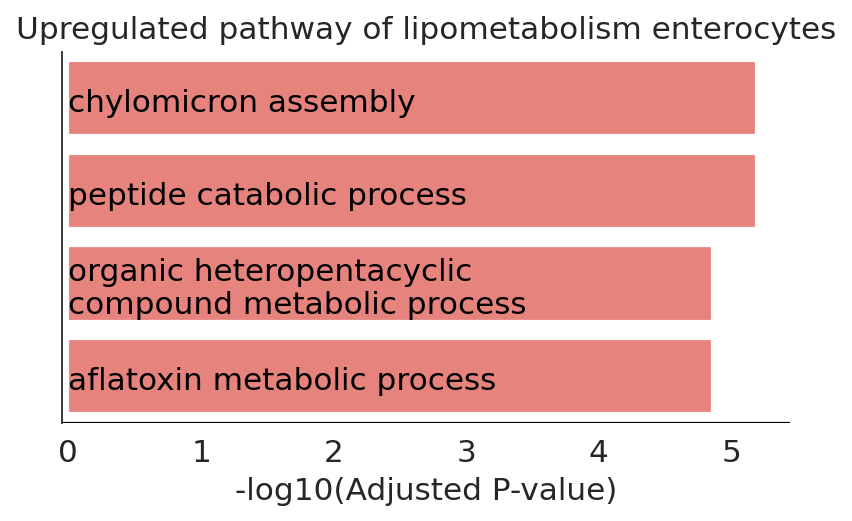

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('white')

enr = enr.sort_values(by='-log10(Adjusted P-value)', ascending=False)  
enr = enr.head(4) 


enr['Term'] = enr['Term'].str.replace('\(GO:\d+\)', '', regex=True)
enr['-log10(Adjusted P-value)'] = -np.log10(enr['Adjusted P-value'])
enr_sorted = enr.sort_values('-log10(Adjusted P-value)', ascending=False)
enr_sorted['Term'] = enr_sorted['Term'].apply(split_long_name)

f, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharex=True) 
colors = ['#f8736a']*len(enr.index)  
barplot = sns.barplot(x="-log10(Adjusted P-value)", y="Term", data=enr_sorted, palette=colors, ax=ax)

sns.set_color_codes("muted")
sns.despine(bottom=True)

for i, p in enumerate(ax.patches):  #
    ax.text(p.get_x(), p.get_y() + p.get_height() / 2. + 0.05, f'{enr_sorted["Term"].iloc[i]}', 
            ha='left', va='center', color='black')

ax.axhline(y=3.5, color='black', linewidth=1)
ax.set_title('Upregulated pathway of lipometabolism enterocytes')
ax.set_ylabel('')
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.set_xlim(left=-0.05)  

plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout(h_pad=2)
plt.savefig("Gastric/Figure_new/Figure5/Figure5_F_1",dpi=300,bbox_inches = 'tight')
plt.show()

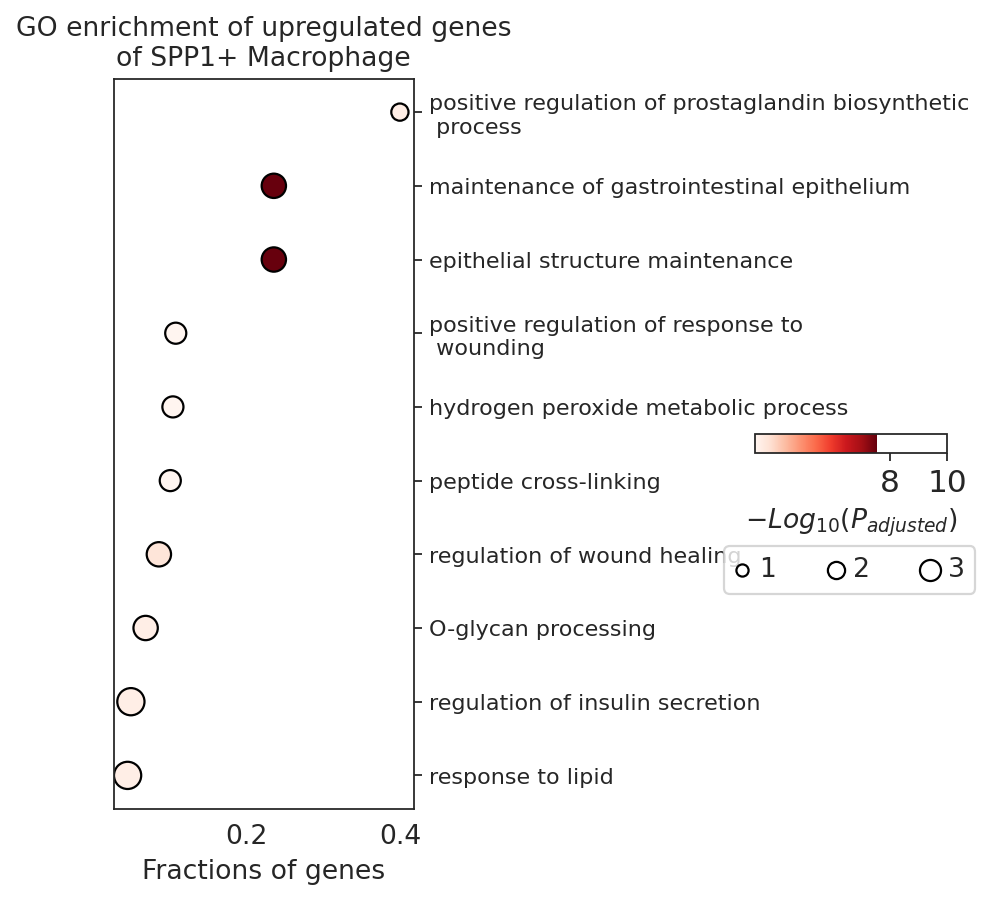

In [82]:
pathway_dict=ov.utils.geneset_prepare('Gastric/Reference/genesets/GO_Biological_Process_2021.txt',organism='Human')
deg_genes = dds.result.loc[(dds.result['sig']!='normal')&(dds.result['log2FC']<0)].index.tolist()
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='Human')
ax = ov.bulk.geneset_plot(enr,figsize=(2.4,6),fig_title='GO enrichment of upregulated genes\nof SPP1+ Macrophage',
                          node_size=[1, 2, 3],
                          cax_loc=[1.85, 0.52, 0.5, 0.02],
                          bbox_to_anchor_used=(-0.23, -8),node_diameter=30,custom_ticks=[8,10],
                        cmap='Reds')

In [83]:
enr['-log10(Adjusted P-value)'] = -np.log10(enr['Adjusted P-value'])
enr = enr.sort_values(by='-log10(Adjusted P-value)', ascending=False) 
enr = enr.head(4)  
enr

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,logp,logc,num,fraction,-log10(Adjusted P-value)
225,CUSTOM22623382030336,maintenance of gastrointestinal epithelium (GO...,4/17,0.000001,0.000526,54.659377,TFF3;MUC4;VSIG1;TFF2,7.549355,4.001121,4,0.235294,3.278643
143,CUSTOM22623382030336,epithelial structure maintenance (GO:0010669),4/17,0.000001,0.000526,54.659377,TFF3;MUC4;VSIG1;TFF2,7.549355,4.001121,4,0.235294,3.278643
795,CUSTOM22623382030336,regulation of wound healing (GO:0061041),4/47,0.000081,0.023514,20.105910,FOXA2;ANXA1;DUOX2;ADRA2A,3.750146,3.001014,4,0.085106,1.628668
14,CUSTOM22623382030336,O-glycan processing (GO:0016266),4/59,0.000198,0.029086,16.040796,MUC5AC;MUC4;MUC5B;MUC1,3.537513,2.775135,4,0.067797,1.536322


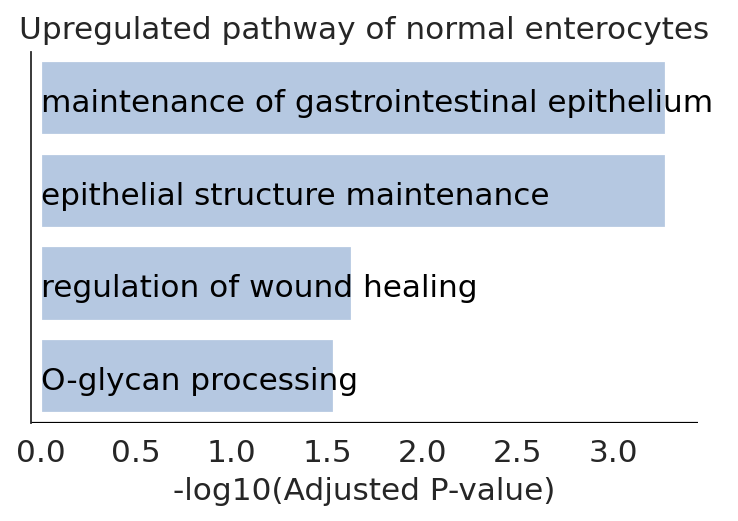

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('white')


enr = enr.sort_values(by='-log10(Adjusted P-value)', ascending=False) 
enr = enr.head(6)  

enr['Term'] = enr['Term'].str.replace('\(GO:\d+\)', '', regex=True)
enr['-log10(Adjusted P-value)'] = -np.log10(enr['Adjusted P-value'])
enr_sorted = enr.sort_values('-log10(Adjusted P-value)', ascending=False)
enr_sorted['Term'] = enr_sorted['Term'].apply(split_long_name)

f, ax = plt.subplots(1, 1, figsize=(5,3.5), sharex=True) 
colors = ['#aec7e8']*len(enr.index)  
barplot = sns.barplot(x="-log10(Adjusted P-value)", y="Term", data=enr_sorted, palette=colors, ax=ax)

sns.set_color_codes("muted")
sns.despine(bottom=True)

for i, p in enumerate(ax.patches):  
    ax.text(p.get_x(), p.get_y() + p.get_height() / 2. + 0.05, f'{enr_sorted["Term"].iloc[i]}', 
            ha='left', va='center', color='black')

ax.axhline(y=3.5, color='black', linewidth=1)
ax.set_title('Upregulated pathway of normal enterocytes')
ax.set_ylabel('')
#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')
ax.set_xlim(left=-0.05)  #

plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout(h_pad=2)
plt.savefig("Gastric/Figure_new/Figure5/Figure5_F_2",dpi=300,bbox_inches = 'tight')
plt.show()